# Setup

In [0]:
# Data upload
from google.colab import files
import io

# Pandas and numpy
import numpy as np
import pandas as pd

# Pyplot and sns
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
import re
import nltk
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Sklearn
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier


In [0]:
%%capture
nltk.download("popular")

In [3]:
# Test GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Part 1: Build a classification model using text data

In part one of the homework, you will solve a text classification task.

You can download the following data-sets from the HW data folder on the course website:
* HW4_Text_train_data.csv
* HW4_text_test_data.csv

In [3]:
train_csv = files.upload()

Saving HW4_Text_train_data.csv to HW4_Text_train_data.csv


In [4]:
test_csv = files.upload()

Saving HW4_Text_test_data.csv to HW4_Text_test_data.csv


In [5]:
df_train = pd.read_csv(io.BytesIO(train_csv['HW4_Text_train_data.csv']))
df_train.head()

,Review,Recommended
0,"""go to"" please offer a maxi for mature custome...",1
1,"""go to"" tee for sz 10+ women.Women who want so...",1
2,"""long and warm"".These leg warmers are perfect ...",1
3,"""tweed"" dress.I bought this dress for my siste...",1
4,#1 stunna.I am in lust with this fabulous dres...,1


In [6]:
df_test = pd.read_csv(io.BytesIO(test_csv['HW4_Text_test_data.csv']))
df_test.head()

,Review,Recommended
0,"""beach business"".Great for the beachy business...",1
1,"""formal pajamas"".These are super comfy and so ...",1
2,"""perfect with jeans"".Great with leggings.perfe...",1
3,"""won't stretch"" tags are misleading.The tag on...",1
4,$200 piece of polyester.A $200 piece of polyes...,0


We are trying to determine whether a reviewer will recommend a product or not based on each review.

In a real application this might allow us to find out what is good or bad about certain products or to feature more typical reviews (like a very critical and a very positive one).

Use cross-validation to evaluate the results. Use a metric that’s appropriate for imbalanced classification (AUC or average precision for example), and inspect all models by visualizing the coefficients.

To complete part one of the homework do the following:

Import the text data, vectorize the review column into an X matrix.  Then run at least three models and select a single best model.  Note that you can also create three models that simply use different types of explanatory variables such as a logistic regression with different n grams or different tokenizers.  Be sure to explain your choice and evaluate this model using the test set.


## Initial pre-processing of text

In [0]:
# Lower case, remove punctuation
lemmatiser = WordNetLemmatizer()

def pre_processing(text):
  text_lower = text.lower()
  text_rm_punct = re.sub(r"[^A-z\s]+", " ", text_lower)
  return (text_rm_punct)

df_train_X = df_train['Review'].apply(pre_processing)

## Vectorisation of Features and Find Best params with Gridsearch CV

**Using Precision as the metric**

Precision is used because
* It is recommended in the instructions
* AUC, the other recommendation, is a good overall model evaluation metric but doesn't really make sense without plotting the ROC and seeing if your model performs best at the chosen threshold (and choosing a tradeoff between true positives and false positives), and I didn't want to get into that for this assignment
* Precision makes sense because you want to minimise the number of false positives. On an amazon like site...
  - Falsely classifying a non-recommendation as a potential recommendation might mean giving it a prominent position that turns off other buyers
  - On the other hand a false negative just loses you one review to show, and you have thousands.

**Side note**

Have reduced number of parameters searched for in the grids, and use only 5-fold CV, to minimise training time. Spent a lot of time trying to run a random forest gridsearch that didn't finish overnight :/

In [0]:
# Lemmatisation, Stopwords removal, Vectorisation
class LemmaTokenizer:
  def __init__(self):
    self.wnl = WordNetLemmatizer()
  def __call__(self, doc):
    return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

stop_words = ENGLISH_STOP_WORDS.union(['ha', 'le', 'u', 'wa'])

vectoriser = TfidfVectorizer(stop_words = stop_words,
                             tokenizer = LemmaTokenizer(),
                             ngram_range = (1, 2))

count_vec = CountVectorizer(stop_words = stop_words,
                             tokenizer = LemmaTokenizer(),
                             ngram_range = (1, 2))

In [0]:
# Model objects
logistic_regression = LogisticRegression(penalty = 'l2',
                                         C = 1.0,
                                         max_iter = 1000)
knn = KNeighborsClassifier()

In [0]:
# Pipelines
log_reg_pipe = Pipeline(steps = [('vectorise', vectoriser),
                                 ('log_reg', logistic_regression)]
                       )

knn_pipe = Pipeline(steps = [('vectorise', vectoriser),
                             ('knn', knn)]
                    )

knn_pipe_count_vec  = Pipeline(steps = [('vectorise', count_vec),
                                        ('knn', knn)]
                              )

In [0]:
# Param grids
vec_params = {'vectorise__ngram_range': [(1, 1), (1, 2), (2, 2)]}

log_reg_params = {'log_reg__C': [0.1, 1, 10]}
log_reg_param_grid = {**vec_params, **log_reg_params}

knn_params = {'knn__n_neighbors': [1, 3, 5]}
knn_param_grid = {**vec_params, **knn_params}

# Grid objects

log_reg_grid = GridSearchCV(log_reg_pipe,
                            log_reg_param_grid,
                            cv = 5,
                            scoring = 'precision')

knn_grid = GridSearchCV(knn_pipe,
                       knn_param_grid,
                        cv = 5,
                        scoring = 'precision',
                        verbose = 2)

knn_grid_count_vec = GridSearchCV(knn_pipe_count_vec,
                                  knn_param_grid,
                                  cv = 5,
                                  scoring = 'precision',
                                  verbose = 2)


In [0]:
log_reg_grid.fit(df_train_X, y = df_train['Recommended'])

In [106]:
print("Log Reg best score: {:.4f}"\
      .format(log_reg_grid.best_score_))
print("Log Reg best params: {}"\
      .format(log_reg_grid.best_params_))

Log Reg best score: 0.9192
Log Reg best params: {'log_reg__C': 10, 'vectorise__ngram_range': (1, 1)}


In [0]:
knn_grid.fit(df_train_X, y = df_train['Recommended'])
# Output from the fit was removed - verbose was set to 2 to see how long it 
# will take for the gridsearch to run, but the output was quite lengthy as a 
# result, and so was removed

In [15]:
print("Nearest Neighbors best score: {:.4f}"\
      .format(knn_grid.best_score_))
print("Nearest Neighbors best params: {}"\
      .format(knn_grid.best_params_))

Nearest Neighbors best score: 0.8736
Nearest Neighbors best params: {'knn__n_neighbors': 1, 'vectorise__ngram_range': (1, 1)}


In [0]:
knn_grid_count_vec.fit(df_train_X, y = df_train['Recommended'])
# Output from the fit was removed - verbose was set to 2 to see how long it 
# will take for the gridsearch to run, but the output was quite lengthy as a 
# result, and so was removed

In [14]:
print("Nearest Neighbours (Count vec instead of TFIDF) best score: {:.4f}"\
      .format(knn_grid_count_vec.best_score_))
print("Nearest Neighbours (Count vec instead of TFIDF) best params: {}"\
      .format(knn_grid_count_vec.best_params_))

Nearest Neighbours (Count vec instead of TFIDF) best score: 0.8465
Nearest Neighbours (Count vec instead of TFIDF) best params: {'knn__n_neighbors': 1, 'vectorise__ngram_range': (1, 1)}


In [92]:
pipeline.fit(df_train_X, y = df_train['Recommended']).predict(df_train_X)

array([1, 1, 1, ..., 1, 1, 1])

At this point we know that the logistic regression is the best, and the KNN models don't measure up. Will run 3 different logistic regressions with CV and to visualise the coefficients, since KNN doesn't have coefficients or feature importance metrics.

Will use tfidf for all 3, since it seems that count vectorisation dropped performance with KNN

## CV of logistic regressions

In [0]:
tfidf_vec_1 = TfidfVectorizer(stop_words = stop_words,
                              tokenizer = LemmaTokenizer(),
                              ngram_range = (1, 1))

tfidf_vec_2 = TfidfVectorizer(stop_words = stop_words,
                             tokenizer = LemmaTokenizer(),
                             ngram_range = (1, 2))

tfidf_vec_3 = TfidfVectorizer(stop_words = stop_words,
                             tokenizer = LemmaTokenizer(),
                             ngram_range = (2, 2))

log_reg_1 = LogisticRegression(penalty = 'l2', C = 10, max_iter = 1000)
log_reg_2 = LogisticRegression(penalty = 'l2', C = 10, max_iter = 1000)
log_reg_3 = LogisticRegression(penalty = 'l2', C = 10, max_iter = 1000)


In [147]:
tfidf_vec_1 = tfidf_vec_1.fit(df_train_X)
tfidf_vec_X_1 = tfidf_vec_1.transform(df_train_X)
lr1 = log_reg_1.fit(tfidf_vec_X_1, df_train['Recommended'])

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [95]:
tfidf_vec_2 = tfidf_vec_2.fit(df_train_X)
tfidf_vec_X_2 = tfidf_vec_2.transform(df_train_X)
lr2 = log_reg_2.fit(tfidf_vec_X_2, df_train['Recommended'])

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [96]:
tfidf_vec_3 = tfidf_vec_3.fit(df_train_X)
tfidf_vec_X_3 = tfidf_vec_3.transform(df_train_X)
lr3 = log_reg_3.fit(tfidf_vec_X_3, df_train['Recommended'])

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [0]:
skfold = StratifiedKFold(shuffle = True, random_state = 123)

In [98]:
cross_val_score(lr1,
                X = tfidf_vec_X_1,
                y = df_train['Recommended'],
                scoring = 'precision',
                cv = skfold).mean()

0.9219997110851198

In [99]:
cross_val_score(lr2,
                X = tfidf_vec_X_2,
                y = df_train['Recommended'],
                scoring = 'precision',
                cv = skfold).mean()

0.9097944581035323

In [100]:
cross_val_score(lr3,
                X = tfidf_vec_X_3,
                y = df_train['Recommended'],
                scoring = 'precision',
                cv = skfold).mean()

0.8531138492168961

## Visualise coefficients

In [0]:
lr1_coefs = pd.DataFrame(np.transpose(lr1.coef_),
                         index = np.array(tfidf_vec_1.get_feature_names()),
                         columns = ['coefficients'])\
  .sort_values(by='coefficients', ascending=False)\
  .reset_index()
lr1_coefs = lr1_coefs.head(10).append(lr1_coefs.tail(10))

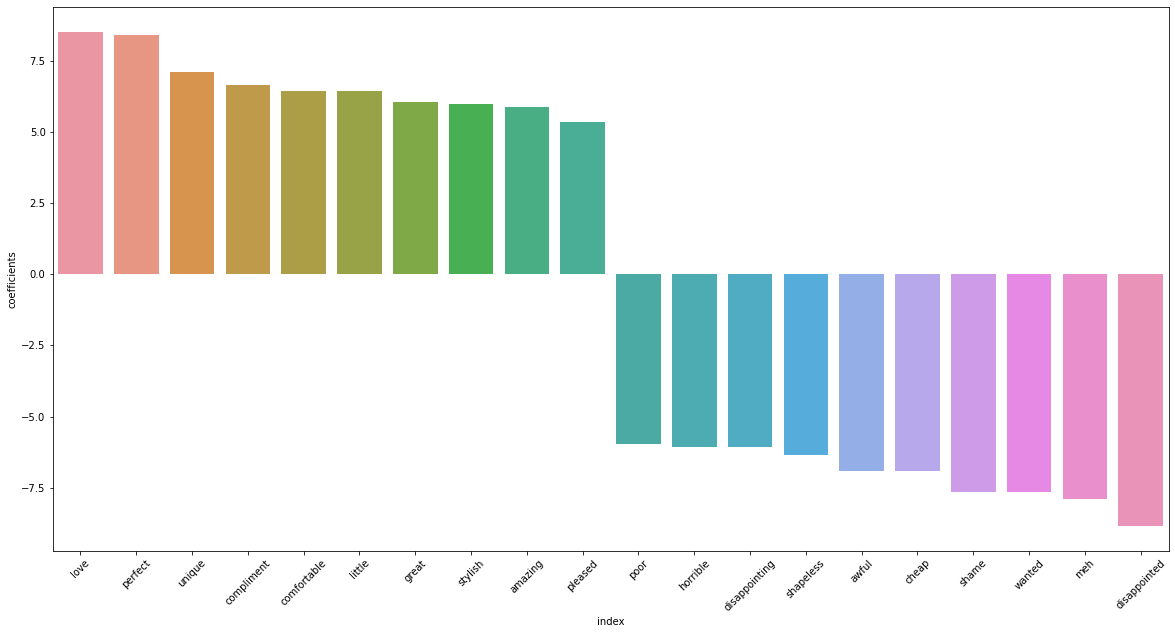

In [136]:
plt.figure(figsize=(20,10))
lr1_plot = sns.barplot(x="index", y="coefficients", data = lr1_coefs)
lr1_plot.set_xticklabels(lr1_plot.get_xticklabels(), rotation=45)
plt.show()

In [0]:
lr2_coefs = pd.DataFrame(np.transpose(lr2.coef_),
                         index = np.array(tfidf_vec_2.get_feature_names()),
                         columns = ['coefficients'])\
  .sort_values(by='coefficients', ascending=False)\
  .reset_index()
lr2_coefs = lr2_coefs.head(10).append(lr2_coefs.tail(10))

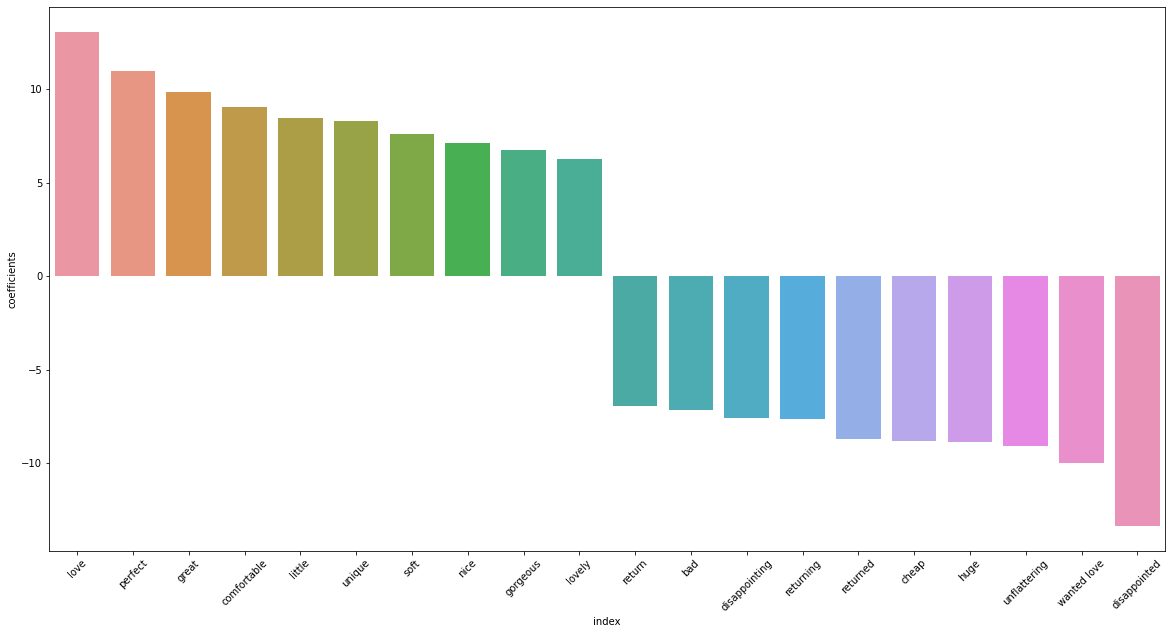

In [139]:
plt.figure(figsize=(20,10))
lr2_plot = sns.barplot(x="index", y="coefficients", data = lr2_coefs)
lr2_plot.set_xticklabels(lr2_plot.get_xticklabels(), rotation=45)
plt.show()

In [0]:
lr3_coefs = pd.DataFrame(np.transpose(lr3.coef_),
                         index = np.array(tfidf_vec_3.get_feature_names()),
                         columns = ['coefficients'])\
  .sort_values(by='coefficients', ascending=False)\
  .reset_index()
lr3_coefs = lr3_coefs.head(10).append(lr3_coefs.tail(10))

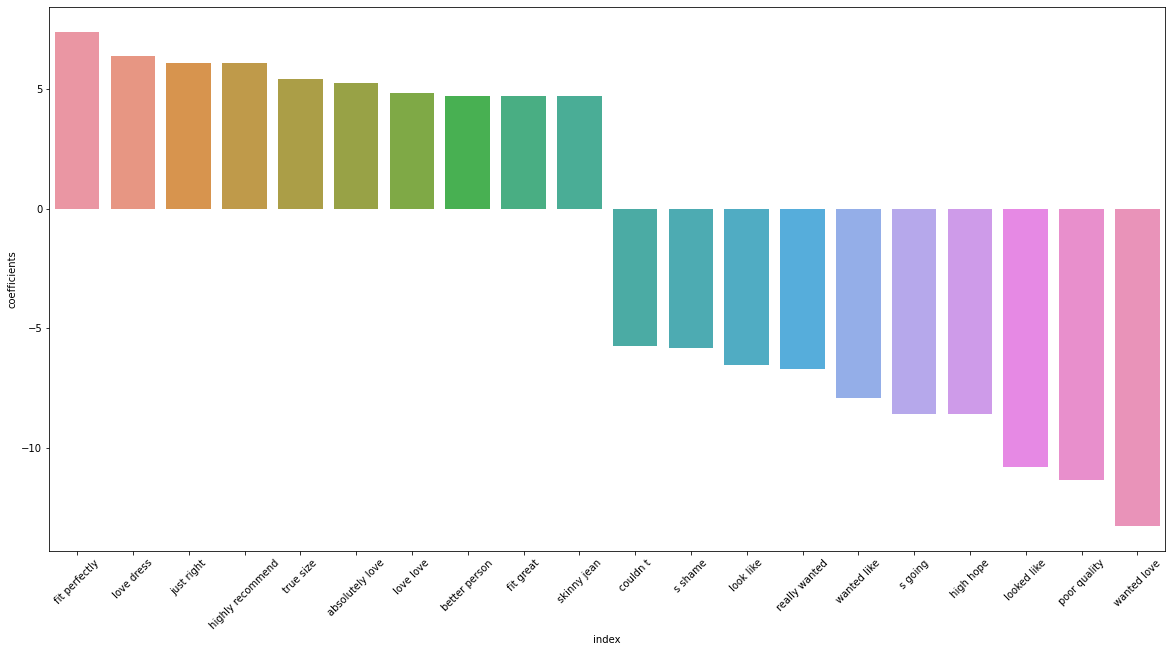

In [142]:
plt.figure(figsize=(20,10))
lr3_plot = sns.barplot(x="index", y="coefficients", data = lr3_coefs)
lr3_plot.set_xticklabels(lr3_plot.get_xticklabels(), rotation=45)
plt.show()

## Choice of Best Model

All 3 models we evaluate here seem to do a reasonably good job.
* High precision scores for all 3 models
* Positively weighted coefficients for all 3 models correspond to really positive words and phrases
* Negatively weighted coefficients for all 3 models correspond to disappointment

As expected, the model the gridsearch chose, using TFIDF vectoriser with only 1-grams, and a L2 logistic regression with C = 10 performs best (lr1). Although the strongest coefficients don't really differetiate the models, this one has the highest precision score.

## Evaluate on Test Set

In [148]:
df_test_X = df_test['Review'].apply(pre_processing)
tfidf_vec_X_1_test = tfidf_vec_1.transform(df_test_X)
y_pred = lr1.predict(tfidf_vec_X_1_test)
precision_score(df_test['Recommended'], y_pred)

0.9215317011927181

Our model does very well on the test set with 92% precision. This score is similar to the mean CV score

# Part 2: Build a predictive neural network using Keras

To complete part two of the homework do the following:

Run a multilayer perceptron (feed forward neural network) with two hidden layers on the iris dataset using the keras Sequential interface.

Data can be imported via the following link:

http://vincentarelbundock.github.io/Rdatasets/csv/datasets/iris.csv

Include code for selecting the number of hidden units using GridSearchCV and evaluation on a test-set.  Describe the differences in the predictive accuracy of models with different numbers of hidden units.  Describe the predictive strength of your best model.  Be sure to explain your choice and evaluate this model using the test set.

## Setup

In [204]:
df_iris = pd.read_csv('http://vincentarelbundock.github.io/Rdatasets/csv/datasets/iris.csv')
df_iris.head()

,Unnamed: 0,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,1,5.1,3.5,1.4,0.2,setosa
1,2,4.9,3.0,1.4,0.2,setosa
2,3,4.7,3.2,1.3,0.2,setosa
3,4,4.6,3.1,1.5,0.2,setosa
4,5,5.0,3.6,1.4,0.2,setosa


In [205]:
# Find number of classes
df_iris['Species'].value_counts()

versicolor    50
virginica     50
setosa        50
Name: Species, dtype: int64

In [0]:
features = df_iris[['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width']]
target = df_iris[['Species']]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target,
                                                    test_size = 0.2,
                                                    shuffle = True,
                                                    random_state = 123)

## GridSearch

In [0]:
def create_model(learn_rate=0.01, hidden_units = 10):
	# create model
  model = Sequential()
  model.add(Dense(units = hidden_units, activation = 'relu', input_dim = 4))
  model.add(Dense(units = hidden_units, activation = 'relu'))
  model.add(Dense(units=3, activation='softmax'))
    # Compile model
  optimizer = SGD(lr = learn_rate)
  model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = optimizer,
                  metrics = ['accuracy'])
  return model

model = KerasClassifier(build_fn = create_model, epochs = 50, verbose = 0)

param_grid = {'hidden_units': [5, 10, 15, 20],
              'learn_rate': [0.01, 0.1, 0.25]}

grid = GridSearchCV(estimator = model,
                    param_grid = param_grid,
                    scoring = 'accuracy',
                    cv = 5,
                    verbose = 1)
            

In [209]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   31.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f06582fc7f0>,
             iid='deprecated', n_jobs=None,
             param_grid={'hidden_units': [5, 10, 15, 20],
                         'learn_rate': [0.01, 0.1, 0.25]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [210]:
print("Neural Net best score: {:.4f}"\
      .format(grid.best_score_))
print("Neural Net best params: {}"\
      .format(grid.best_params_))

Neural Net best score: 0.9417
Neural Net best params: {'hidden_units': 20, 'learn_rate': 0.01}


In [211]:
pd.DataFrame(grid.cv_results_)[['params', 'mean_test_score']]\
  .sort_values(['mean_test_score'], ascending = False)

,params,mean_test_score
9,"{'hidden_units': 20, 'learn_rate': 0.01}",0.941667
10,"{'hidden_units': 20, 'learn_rate': 0.1}",0.916667
6,"{'hidden_units': 15, 'learn_rate': 0.01}",0.875000
7,"{'hidden_units': 15, 'learn_rate': 0.1}",0.875000
3,"{'hidden_units': 10, 'learn_rate': 0.01}",0.858333
1,"{'hidden_units': 5, 'learn_rate': 0.1}",0.800000
11,"{'hidden_units': 20, 'learn_rate': 0.25}",0.800000
4,"{'hidden_units': 10, 'learn_rate': 0.1}",0.725000
2,"{'hidden_units': 5, 'learn_rate': 0.25}",0.658333
0,"{'hidden_units': 5, 'learn_rate': 0.01}",0.608333


In general, using a metric of average accuracy across 5-fold CV

* 20 hidden units tends to be the best performing (though learning rate of 0.25 appears to be overfit)
* 5 hidden units tends to be the poorest performing
* 15 hidden units tends to do better depending on the learning rate (though learning rate of 0.25 appears to be overfit)
* The performance of 10 hidden units depends heavily on the learning rate

The best model has 20 hidden units and a learning rate of 0.1. It is the best model as it has the strongest accuracy score. This score is objectively good - at 0.94, it is well above chance (with 3 classes, chance is about 0.33). The next closest models also have a high accuracy score, though at least 2% loewr than the best model.


## Evaluation of Best Model on Test Set

In [212]:
y_pred = grid.predict(X_test)
accuracy_score(y_true = y_test,
               y_pred = y_pred)

0.9666666666666667

The best model performs well on the test set as well, achieving a classification accuracy of about 96.7%